In [1]:
import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score
import numpy as np
import seaborn as sns

from experiments.experiments3.auxiliary.auxiliary import construct_by_quantiles, construct_by_kmeans, construct_by_uniform
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
from bamt_inherited.networks.discrete import DiscreteBNGI
from bamt.nodes import DiscreteNode

import copy

imagespath = 'C:/Users/Acer/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/images'

datapath = 'C:/Users/Acer/PycharmProjects/GIEBN/datasets/files/csv/sachs.csv'
structurepath = 'C:/Users/Acer/PycharmProjects/GIEBN/datasets/files/txt/sachs.txt'

SEED = 42

In [2]:
data = pd.read_csv(datapath)
data.head()

,Unnamed: 0,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,1,LOW,AVG,AVG,LOW,AVG,AVG,LOW,AVG,AVG,HIGH,LOW
1,2,AVG,HIGH,LOW,LOW,LOW,LOW,LOW,HIGH,LOW,LOW,LOW
2,3,LOW,AVG,LOW,LOW,LOW,LOW,AVG,AVG,AVG,LOW,LOW
3,4,AVG,AVG,LOW,LOW,LOW,AVG,HIGH,HIGH,LOW,AVG,LOW
4,5,AVG,HIGH,AVG,LOW,AVG,LOW,AVG,AVG,LOW,LOW,LOW


In [3]:
data.drop(columns="Unnamed: 0", inplace=True)
variables = data.columns.tolist()

In [4]:
from sklearn.preprocessing import OrdinalEncoder

In [5]:
data_enc_arr = OrdinalEncoder(categories=[["LOW", "AVG", "HIGH"]]*len(variables), dtype=np.int8).fit_transform(data)
data_enc = pd.DataFrame(data_enc_arr, columns=variables)

In [6]:
data_enc

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,0,1,1,0,1,1,0,1,1,2,0
1,1,2,0,0,0,0,0,2,0,0,0
2,0,1,0,0,0,0,1,1,1,0,0
3,1,1,0,0,0,1,2,2,0,1,0
4,1,2,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1,1,0,0,0,0,1,1,0,0
4996,0,1,0,0,2,0,1,2,0,0,0
4997,0,1,0,0,0,2,1,1,1,2,0
4998,0,1,1,1,1,0,1,1,2,0,1


In [7]:
edges = list()
with open(structurepath) as f:
    edges = [e[:-1].split(" ") for e in f.readlines()]
edges

[['Erk', 'Akt'],
 ['Mek', 'Erk'],
 ['PIP3', 'PIP2'],
 ['PKA', 'Akt'],
 ['PKA', 'Erk'],
 ['PKA', 'Jnk'],
 ['PKA', 'Mek'],
 ['PKA', 'P38'],
 ['PKA', 'Raf'],
 ['PKC', 'Jnk'],
 ['PKC', 'Mek'],
 ['PKC', 'P38'],
 ['PKC', 'PKA'],
 ['PKC', 'Raf'],
 ['Plcg', 'PIP2'],
 ['Plcg', 'PIP3'],
 ['Raf', 'Mek'],
 ['Erk', 'Akt'],
 ['Mek', 'Erk'],
 ['PIP3', 'PIP2'],
 ['PKA', 'Akt'],
 ['PKA', 'Erk'],
 ['PKA', 'Jnk'],
 ['PKA', 'Mek'],
 ['PKA', 'P38'],
 ['PKA', 'Raf'],
 ['PKC', 'Jnk'],
 ['PKC', 'Mek'],
 ['PKC', 'P38'],
 ['PKC', 'PKA'],
 ['PKC', 'Raf'],
 ['Plcg', 'PIP2'],
 ['Plcg', 'PIP3'],
 ['Raf', 'Mek']]

In [8]:
bmrk_bn = Nets.DiscreteBN()

In [9]:
#bmrk_bn.add_nodes(descriptor={"types": {e: "disc" for e in variables}})
bmrk_bn.set_structure(edges=edges, info={"types": {e: "disc" for e in variables}}, nodes=[DiscreteNode(name) for name in variables])

? set_structure дублирует узлы и рёбра, хотя всё передано как надо (по крайней мере в текущей версии BAMT)

In [10]:
def remove_set_parameters_outcomes(bn):
    for i, row in bn.get_info().iterrows():
        n_par = len(row["parents"])
        if n_par:
            row["name"].disc_parents = row["name"].disc_parents[:n_par//2]
            row["parents"] = row["parents"][:n_par//2]
            row["parents_types"] = row["parents_types"][:n_par//2]

In [11]:
remove_set_parameters_outcomes(bmrk_bn)
bmrk_bn.get_info()

,name,node_type,data_type,parents,parents_types
0,PKC,Discrete,disc,[],[]
1,Plcg,Discrete,disc,[],[]
2,PKA,Discrete,disc,[PKC],[disc]
3,PIP3,Discrete,disc,[Plcg],[disc]
4,Jnk,Discrete,disc,"[PKA, PKC]","[disc, disc]"
5,P38,Discrete,disc,"[PKA, PKC]","[disc, disc]"
6,Raf,Discrete,disc,"[PKA, PKC]","[disc, disc]"
7,PIP2,Discrete,disc,"[PIP3, Plcg]","[disc, disc]"
8,Mek,Discrete,disc,"[PKA, PKC, Raf]","[disc, disc, disc]"
9,Erk,Discrete,disc,"[Mek, PKA]","[disc, disc]"


In [12]:
c=bmrk_bn.plot("sachs_benchmark.html")

visualization_result/sachs_benchmark.html


In [13]:
bn = Nets.DiscreteBN()

In [14]:
from pgmpy.estimators import PC, BicScore

In [15]:
bn.add_nodes(bmrk_bn.descriptor)
bn.add_edges(data_enc, scoring_function=("K2", BicScore))

2023-08-15 20:20:15,507 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,510 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,512 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,513 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,515 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,517 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,517 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,519 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,521 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: int8
2023-08-15 20:20:15,527 | ERROR    | GraphUtils.py-node

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [16]:
bn.edges

[['Akt', 'Erk'],
 ['Mek', 'PKA'],
 ['Mek', 'Akt'],
 ['Mek', 'PKC'],
 ['PIP2', 'Plcg'],
 ['PIP2', 'PIP3'],
 ['PIP3', 'Plcg'],
 ['PKA', 'PKC'],
 ['PKA', 'P38'],
 ['PKA', 'Jnk'],
 ['PKA', 'Erk'],
 ['PKA', 'Akt'],
 ['PKC', 'Jnk'],
 ['PKC', 'P38'],
 ['Raf', 'Mek'],
 ['Raf', 'PKC'],
 ['Raf', 'Erk'],
 ['Raf', 'PKA']]

In [17]:
from pgmpy.models import BayesianNetwork as BN

In [18]:
bn.fit_parameters(data=data_enc)

In [19]:
n_states_map = {feat: data_enc[feat].unique().shape[0] for feat in variables}
n_states_map

{'Akt': 3,
 'Erk': 3,
 'Jnk': 3,
 'Mek': 3,
 'P38': 3,
 'PIP2': 3,
 'PIP3': 3,
 'PKA': 3,
 'PKC': 3,
 'Plcg': 3,
 'Raf': 3}

In [20]:
def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds

In [21]:
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)

In [22]:
import yodo.yodo
import matplotlib.pyplot as plt
import torch

In [23]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
for e in cpds:
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

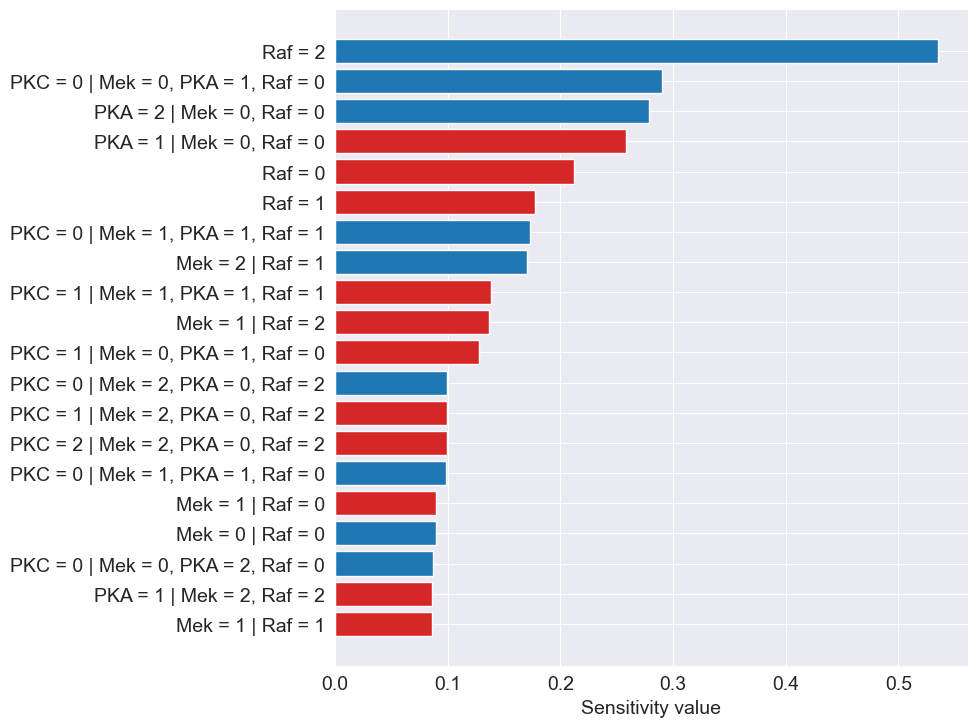

In [24]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'PKC': 0}, nbars=20)

In [25]:
sens = yodo.yodo(pgmpy_bn, probability={'PKC': 0})
sens

{('PIP2',): {'cpt': tensor([0.8416, 0.1020, 0.0564], dtype=torch.float64, names=('PIP2',)),
  'derivative': tensor([-1.1102e-16,  5.5511e-17,  5.5511e-17], dtype=torch.float64,
         names=('PIP2',)),
  'sensitivity_value': tensor([1.1102e-16, 5.5511e-17, 5.5511e-17], dtype=torch.float64,
         names=('PIP2',)),
  'proximity': tensor([nan, nan, nan], dtype=torch.float64, names=('PIP2',)),
  'second_derivative': tensor([0., -0., -0.], dtype=torch.float64, names=('PIP2',)),
  'largest_first_derivative': tensor([1.1102e-16, 5.5511e-17, 5.5511e-17], dtype=torch.float64)},
 ('Raf',): {'cpt': tensor([0.4968, 0.2908, 0.2124], dtype=torch.float64, names=('Raf',)),
  'derivative': tensor([-0.2117, -0.1773,  0.5350], dtype=torch.float64, names=('Raf',)),
  'sensitivity_value': tensor([0.2117, 0.1773, 0.5350], dtype=torch.float64, names=('Raf',)),
  'proximity': tensor([4.8625e+15,        nan, 2.4187e+15], dtype=torch.float64,
         names=('Raf',)),
  'second_derivative': tensor([ 4.7016

In [26]:
def where(A, m, dimlen=3):
    for i in range(dimlen):
        if np.any(A[i]==m):
            return i

In [27]:
def argmax_coords(A, ndims, dims_sizes):
    res = list()
    A_copy = np.abs(copy.deepcopy(A))
    maxval = A_copy.max()
    for dim in range(ndims):
        i = where(A_copy, maxval, dims_sizes[dim])
        res.append(i)
        A_copy = A_copy[i]
    return (res, maxval)

In [28]:
def find_top_sensitivity_values(info, vars, first, axis):
    a = info[vars]["derivative"].numpy()
    ndims = len(a.shape)
    a_sliced = np.take(a, indices=[first], axis=axis)
    return vars, argmax_coords(a_sliced, ndims-1, a.shape[1:])

def tuple_where(s, v):
    for i, e in enumerate(s):
        if e == v:
            return i
    return -1

In [29]:
def most_influential_parameter(bn):
    res = dict()
    for feat in variables:
        res[feat] = dict()
        for k in range(3):
            sens = yodo.yodo(bn, probability={feat: k})
            max_val = 0
            for c, values in sens.items():
                if feat in c and values["derivative"].names[0] == feat:
                    feat_index = tuple_where(c, feat)
                    max_deriv_data = find_top_sensitivity_values(sens, c, k, feat_index)
                    if max_deriv_data[1][1] > max_val:
                        max_val = max_deriv_data[1][1]
                        res[feat][k] = max_deriv_data
    return res

In [30]:
res = most_influential_parameter(pgmpy_bn)

In [31]:
sens = yodo.yodo(pgmpy_bn, probability={"PKC": 0})

In [32]:
for k, v in sens.items():
    print(k)

('PIP2',)
('Raf',)
('PIP2', 'PIP3')
('Mek', 'Raf')
('PIP2', 'PIP3', 'Plcg')
('Mek', 'PKA', 'Raf')
('Akt', 'Mek', 'PKA')
('Akt', 'Erk', 'PKA', 'Raf')
('Mek', 'PKA', 'PKC', 'Raf')
('Jnk', 'PKA', 'PKC')
('P38', 'PKA', 'PKC')


<Figure size 640x480 with 0 Axes>

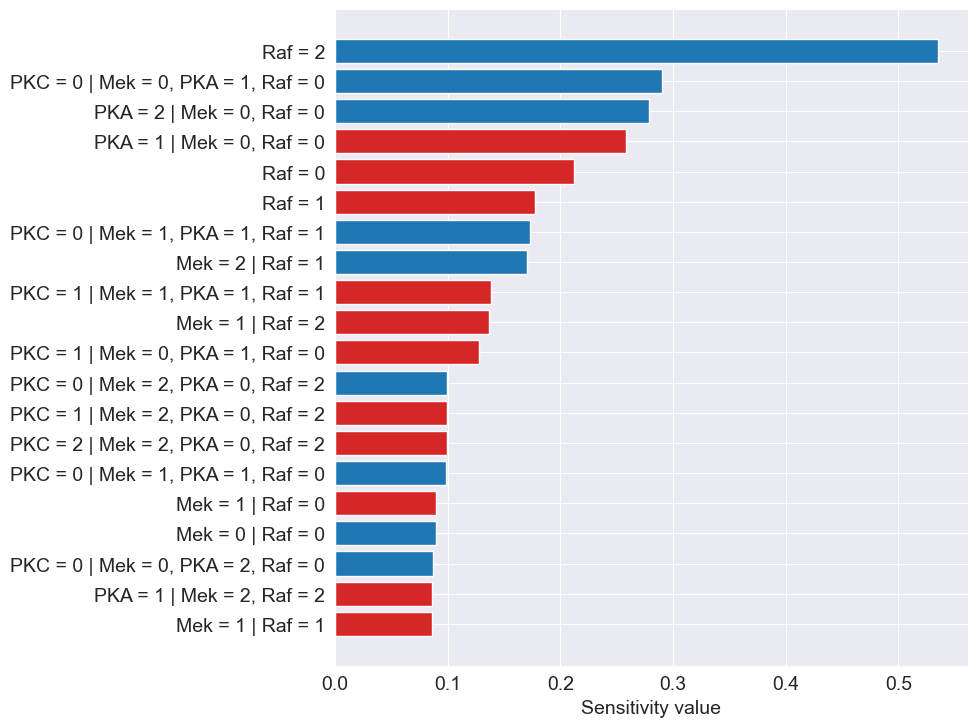

In [33]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'PKC': 0}, nbars=20)

In [34]:
res

{'Akt': {0: (('Akt', 'Mek', 'PKA'), ([0, 0], 0.40080000075688343)),
  1: (('Akt', 'Mek', 'PKA'), ([0, 0], 0.4008000001803207)),
  2: (('Akt', 'Mek', 'PKA'), ([0, 0], 0.40080000003267396))},
 'Erk': {0: (('Akt', 'Erk', 'PKA', 'Raf'), ([0, 0, 1], 0.2617987724948898)),
  1: (('Akt', 'Erk', 'PKA', 'Raf'), ([1, 0, 1], 0.12563100644764086)),
  2: (('Akt', 'Erk', 'PKA', 'Raf'), ([2, 0, 0], 0.08861744614919112))},
 'Jnk': {0: (('Jnk', 'PKA', 'PKC'), ([0, 1], 0.4420000006101122)),
  1: (('Jnk', 'PKA', 'PKC'), ([0, 1], 0.4420000002766216)),
  2: (('Jnk', 'PKA', 'PKC'), ([0, 1], 0.44200000003650924))},
 'Mek': {0: (('Mek', 'Raf'), ([0], 0.49679999999999996)),
  1: (('Mek', 'Raf'), ([0], 0.4968000000000001)),
  2: (('Mek', 'Raf'), ([0], 0.4968))},
 'P38': {0: (('P38', 'PKA', 'PKC'), ([0, 1], 0.44200000195680783)),
  1: (('P38', 'PKA', 'PKC'), ([0, 1], 0.44200000007347395)),
  2: (('P38', 'PKA', 'PKC'), ([0, 1], 0.4420000000532169))},
 'PIP2': {0: (('PIP2',), ([], 1.0)),
  1: (('PIP2',), ([], 1.0))

In [35]:
def extract_yodo_connections(yodo_res):
    grad_edges = list()
    for feat, values in yodo_res.items():
        for k, d in values.items():
            feats, infl_states = d
            i = 0
            for f in feats:
                if f != feat:
                    new_edge = [f+'_'+str(infl_states[0][i]), feat+'_'+str(k)]
                    grad_edges.append(new_edge)
                    i+=1
    return grad_edges

grad_edges = extract_yodo_connections(res)

In [36]:
gbn = DiscreteBNGI(imagespath)
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
gbn.set_edges(grad_edges)

In [37]:
c=bn.plot("sachs_k2.html")

visualization_result/sachs_k2.html


In [38]:
c=gbn.plot("sachs_learnt_grad.html")

C:/Users/Acer/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/images/sachs_learnt_grad.html


In [39]:
for feat in data.columns:
    print(data[feat].value_counts())

LOW     3072
AVG     1521
HIGH     407
Name: Akt, dtype: int64
AVG     3061
HIGH    1242
LOW      697
Name: Erk, dtype: int64
LOW     2667
AVG     1920
HIGH     413
Name: Jnk, dtype: int64
LOW     2891
AVG     1516
HIGH     593
Name: Mek, dtype: int64
LOW     3706
AVG      692
HIGH     602
Name: P38, dtype: int64
LOW     4208
AVG      510
HIGH     282
Name: PIP2, dtype: int64
AVG     2123
HIGH    1720
LOW     1157
Name: PIP3, dtype: int64
AVG     3483
LOW      993
HIGH     524
Name: PKA, dtype: int64
AVG     2386
LOW     2135
HIGH     479
Name: PKC, dtype: int64
LOW     4056
HIGH     528
AVG      416
Name: Plcg, dtype: int64
LOW     2484
AVG     1454
HIGH    1062
Name: Raf, dtype: int64


In [40]:
bmrk_bn.edges

[('Erk', 'Akt'),
 ('Mek', 'Erk'),
 ('PIP3', 'PIP2'),
 ('PKA', 'Akt'),
 ('PKA', 'Erk'),
 ('PKA', 'Jnk'),
 ('PKA', 'Mek'),
 ('PKA', 'P38'),
 ('PKA', 'Raf'),
 ('PKC', 'Jnk'),
 ('PKC', 'Mek'),
 ('PKC', 'P38'),
 ('PKC', 'PKA'),
 ('PKC', 'Raf'),
 ('Plcg', 'PIP2'),
 ('Plcg', 'PIP3'),
 ('Raf', 'Mek'),
 ('Erk', 'Akt'),
 ('Mek', 'Erk'),
 ('PIP3', 'PIP2'),
 ('PKA', 'Akt'),
 ('PKA', 'Erk'),
 ('PKA', 'Jnk'),
 ('PKA', 'Mek'),
 ('PKA', 'P38'),
 ('PKA', 'Raf'),
 ('PKC', 'Jnk'),
 ('PKC', 'Mek'),
 ('PKC', 'P38'),
 ('PKC', 'PKA'),
 ('PKC', 'Raf'),
 ('Plcg', 'PIP2'),
 ('Plcg', 'PIP3'),
 ('Raf', 'Mek')]

In [41]:
bn.update_descriptor()

In [42]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,PIP2,Discrete,disc,[],[]
1,Raf,Discrete,disc,[],[]
2,PIP3,Discrete,disc,[PIP2],[disc]
3,Mek,Discrete,disc,[Raf],[disc]
4,Plcg,Discrete,disc,"[PIP2, PIP3]","[disc, disc]"
5,PKA,Discrete,disc,"[Mek, Raf]","[disc, disc]"
6,PKC,Discrete,disc,"[Mek, PKA, Raf]","[disc, disc, disc]"
7,Akt,Discrete,disc,"[Mek, PKA]","[disc, disc]"
8,Jnk,Discrete,disc,"[PKA, PKC]","[disc, disc]"
9,P38,Discrete,disc,"[PKA, PKC]","[disc, disc]"


In [43]:
bmrk_bn.fit_parameters(data_enc)

In [44]:
bmrk_bn.distributions

{'PKC': {'cprob': [0.427, 0.4772, 0.0958], 'vals': ['0', '1', '2']},
 'Plcg': {'cprob': [0.8112, 0.0832, 0.1056], 'vals': ['0', '1', '2']},
 'PKA': {'cprob': {"['0']": [0.3981264637002342,
    0.38173302107728335,
    0.2201405152224824],
   "['1']": [0.05574182732606874, 0.9262363788767812, 0.018021793797150035],
   "['2']": [0.020876826722338208, 0.9561586638830898, 0.022964509394572025]},
  'vals': ['0', '1', '2']},
 'PIP3': {'cprob': {"['0']": [0.22066074950690334,
    0.4430473372781065,
    0.33629191321499013],
   "['1']": [0.07692307692307693, 0.23317307692307693, 0.6899038461538461],
   "['2']": [0.4356060606060606, 0.4337121212121212, 0.13068181818181818]},
  'vals': ['0', '1', '2']},
 'Jnk': {'cprob': {"['0', '0']": [0.2952941176470588,
    0.23294117647058823,
    0.4717647058823529],
   "['0', '1']": [0.6015037593984962, 0.39849624060150374, 0.0],
   "['0', '2']": [0.0, 1.0, 0.0],
   "['1', '0']": [0.558282208588957, 0.44171779141104295, 0.0],
   "['1', '1']": [0.613574660

In [45]:
cpds_bmrk = collect_all_cpds(bmrk_bn.get_info(), bmrk_bn.distributions, n_states_map)

In [46]:
pgmpy_bn_bmrk = BayesianNetwork([list(e) for e in bmrk_bn.edges])
for e in cpds_bmrk:
    pgmpy_bn_bmrk.add_cpds(e)

<Figure size 640x480 with 0 Axes>

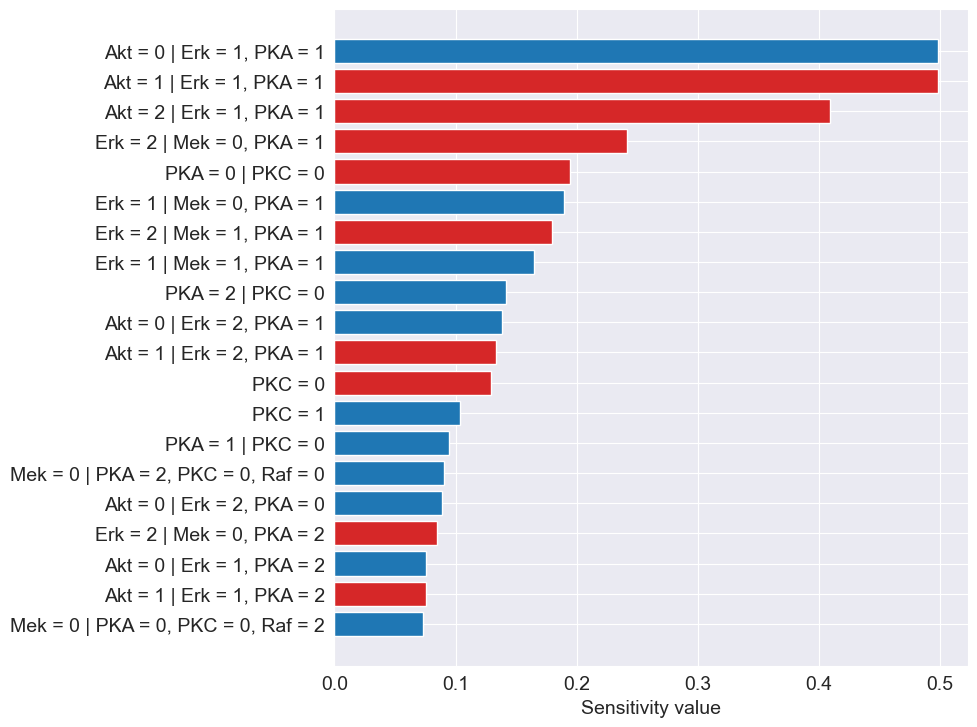

In [47]:
plt.figure()
yodo.plot(pgmpy_bn_bmrk, probability={'Akt': 0}, nbars=20)

In [48]:
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union

In [49]:
nfeat = len(variables)

In [50]:
data

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,LOW,AVG,AVG,LOW,AVG,AVG,LOW,AVG,AVG,HIGH,LOW
1,AVG,HIGH,LOW,LOW,LOW,LOW,LOW,HIGH,LOW,LOW,LOW
2,LOW,AVG,LOW,LOW,LOW,LOW,AVG,AVG,AVG,LOW,LOW
3,AVG,AVG,LOW,LOW,LOW,AVG,HIGH,HIGH,LOW,AVG,LOW
4,AVG,HIGH,AVG,LOW,AVG,LOW,AVG,AVG,LOW,LOW,LOW
...,...,...,...,...,...,...,...,...,...,...,...
4995,AVG,AVG,AVG,LOW,LOW,LOW,LOW,AVG,AVG,LOW,LOW
4996,LOW,AVG,LOW,LOW,HIGH,LOW,AVG,HIGH,LOW,LOW,LOW
4997,LOW,AVG,LOW,LOW,LOW,HIGH,AVG,AVG,AVG,HIGH,LOW
4998,LOW,AVG,AVG,AVG,AVG,LOW,AVG,AVG,HIGH,LOW,AVG


In [51]:
pipeline = OrdinalEncoder(categories=[["LOW", "AVG", "HIGH"]]*len(variables), dtype=np.int8,).fit_transform(data)
data_enc = pd.DataFrame(data_enc_arr, columns=variables)

In [52]:
bnres = construct_by_kmeans(data_enc, categoricals=variables,scoring=("K2", K2Score))

In [53]:
bnres["disc_data"]

,Akt0,Akt1,Akt2,Erk1,Erk2,Erk0,Jnk1,Jnk0,Jnk2,Mek0,...,PKA0,PKC1,PKC0,PKC2,Plcg2,Plcg0,Plcg1,Raf0,Raf2,Raf1
0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,0
2,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
3,0,1,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,1,0,0
4,0,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
4996,1,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,0
4997,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4998,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1


In [54]:
states_name_map = lambda x: x[:-1]+"_Low" if x[len(x)-1] == '0' else x[:-1]+"_Mid" if x[len(x)-1] == '1' else x[:-1]+"_High"

In [55]:
bnres["disc_data"].rename(columns={e: states_name_map(e) for e in bnres["disc_data"].columns}, inplace=True)

In [56]:
bnres_giebn = DiscreteBNGI(imagespath)

blacklist = [(x, y) for x, y in product(bnres["disc_data"].columns, bnres["disc_data"].columns) if x.split("_")[0] == y.split("_")[0]]

bnres_giebn.add_nodes({"types": {e: "disc" for e in bnres["disc_data"].columns}})
bnres_giebn.add_edges(bnres["disc_data"], scoring_function=("K2", BicScore), params={'bl_add':blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [57]:
bnres_giebn.fit_parameters(data=bnres["disc_data"])

In [58]:
bnres_giebn.distributions

{'Akt_Mid': {'cprob': [0.6958, 0.3042], 'vals': ['0', '1']},
 'PIP3_High': {'cprob': [0.656, 0.344], 'vals': ['0', '1']},
 'Plcg_Mid': {'cprob': {"['0']": [0.9606707317073171, 0.03932926829268293],
   "['1']": [0.833139534883721, 0.1668604651162791]},
  'vals': ['0', '1']},
 'PIP2_Mid': {'cprob': {"['0', '0']": [0.9308156140907649,
    0.06918438590923517],
   "['0', '1']": [0.9534883720930233, 0.04651162790697675],
   "['1', '0']": [0.889741800418702, 0.11025819958129797],
   "['1', '1']": [0.554006968641115, 0.445993031358885]},
  'vals': ['0', '1']},
 'PIP2_High': {'cprob': {"['0']": [0.9397905759162304, 0.06020942408376963],
   "['1']": [0.9855769230769231, 0.014423076923076929]},
  'vals': ['0', '1']},
 'Plcg_High': {'cprob': {"['0', '0', '0']": [0.9768988449422471,
    0.023101155057752884],
   "['0', '0', '1']": [0.9985196150999259, 0.0014803849000740192],
   "['0', '1', '0']": [0.0, 1.0],
   "['0', '1', '1']": [0.24096385542168675, 0.7590361445783133],
   "['1', '0', '0']": [0.

In [59]:
n_states_map_giebn = {e: 2 for e in bnres["disc_data"].columns}

In [60]:
bnres_giebn_cpds = collect_all_cpds(bnres_giebn.get_info(), bnres_giebn.distributions, n_states_map_giebn)

In [61]:
pgmpy_giebn = BayesianNetwork([list(e) for e in bnres_giebn.edges])
for e in bnres_giebn_cpds:
    pgmpy_giebn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

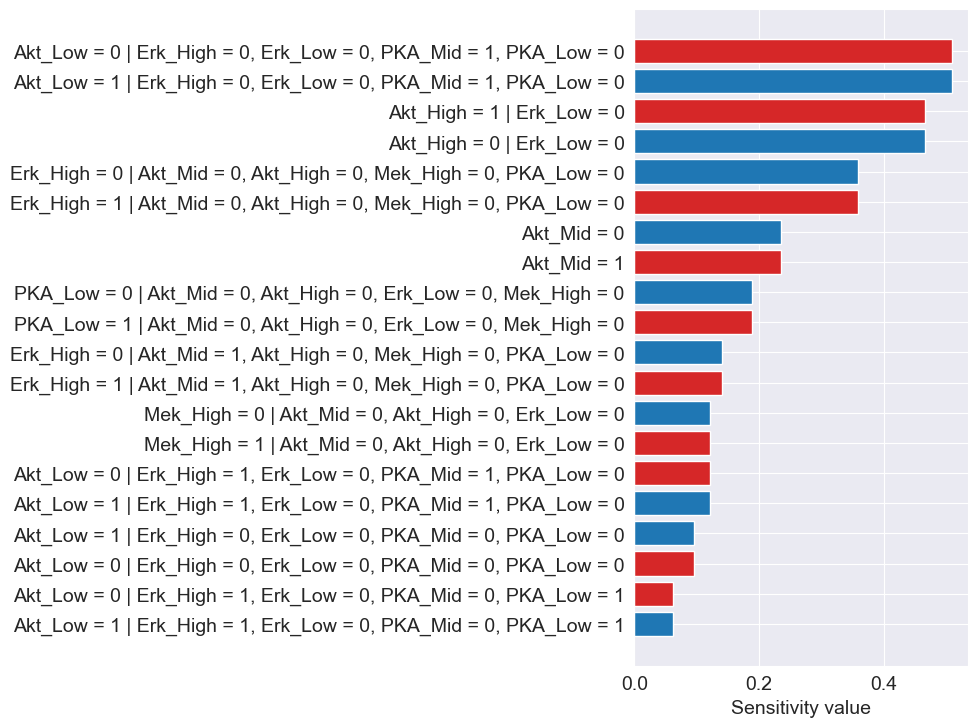

In [62]:
plt.figure()
yodo.plot(pgmpy_giebn, probability={'Akt_Low': 1}, nbars=20)

In [63]:
icat = [0]
icont = list(range(1, 9))

kmeanspipeline = make_pipeline(make_union(
    make_pipeline(FunctionTransformer(lambda x: x[:, icat])),
    make_pipeline(FunctionTransformer(lambda x: x[:, icont]), KBinsDiscretizer(n_bins=3, encode="ordinal", random_state=42, strategy="kmeans"))
),
    FunctionTransformer(lambda x: x.astype("int")))

disc_data = pd.DataFrame(kmeanspipeline.fit_transform(data.values), columns=data.columns)

ValueError: could not convert string to float: 'AVG'